In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten,Conv2D,BatchNormalization,Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
key_points_df= pd.read_csv('data/training_frames_keypoints.csv')

def make_dataset(csv_dir, root_dir):
    
    key_points_frame = pd.read_csv(csv_dir)
    x=[]
    y=[]
    
    for i in range(len(key_points_frame)):
        image_name= os.path.join(root_dir,key_points_frame.iloc[i,0])
        image = cv2.imread(image_name)
        image= image[:,:,0:3]
        #image= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        h, w = image.shape[:2]
        image_resized = cv2.resize(image, (96,96),1)
        #image_resized = image_resized/255.0
        x.append(image_resized)
        
        key_points= key_points_frame.iloc[i, 1:].values
        key_points= key_points.astype('float').reshape(-1,2)
        key_points = key_points * [96/w, 96/h]
        key_points= key_points.reshape(-1)
        y.append(key_points)
        
    x = np.asarray(x, dtype=np.float32)
    y= np.asarray(y, dtype=np.float32)

    #sample={'image':x, 'points':y}
    return x, y

x_train, y_train= make_dataset("data/training_frames_keypoints.csv", "data/training/")

'''x_train = np.asarray(sample['image'], dtype=np.uint8).reshape(3462,96,96,1)
y_train = np.asaray(sample['points'])'''

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [54]:

print(X_train.shape)
print(X_test.shape)


(2769, 96, 96, 3)
(693, 96, 96, 3)


In [3]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters =32, kernel_size =(3,3), padding='same', input_shape=(96,96,3)))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters =32, kernel_size =(3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size =2))

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters =64, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters =64, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters =128, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters =128, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=2))

model.add(tf.keras.layers.Conv2D(filters =256, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters =256, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=2))

model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters =512, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters =512, kernel_size= (3,3),padding='same'))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.1))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(units=136))
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy', 'mae'])


In [4]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.h5', monitor=['val_accuracy'],save_weights_only=True, mode='max', verbose=1)
reduce_lr= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=5, min_delta=0.00001, mode='auto')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
callbacks = [tensorboard_callback,checkpoint]

In [5]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 250 ,batch_size = 128, callbacks=callbacks)  


==================] - 7s 328ms/step - loss: 9.0575 - accuracy: 0.5215 - mae: 2.3788 - val_loss: 2.8526 - val_accuracy: 0.6190 - val_mae: 1.2830
Epoch 189/250
22/22 [==============================] - ETA: 0s - loss: 7.8083 - accuracy: 0.5208 - mae: 2.1895
Epoch 00189: saving model to model_weights.h5
22/22 [==============================] - 8s 361ms/step - loss: 7.8083 - accuracy: 0.5208 - mae: 2.1895 - val_loss: 3.8655 - val_accuracy: 0.6176 - val_mae: 1.5717
Epoch 190/250
22/22 [==============================] - ETA: 0s - loss: 8.1802 - accuracy: 0.5327 - mae: 2.2511
Epoch 00190: saving model to model_weights.h5
22/22 [==============================] - 7s 327ms/step - loss: 8.1802 - accuracy: 0.5327 - mae: 2.2511 - val_loss: 4.4115 - val_accuracy: 0.6190 - val_mae: 1.7315
Epoch 191/250
22/22 [==============================] - ETA: 0s - loss: 8.1594 - accuracy: 0.5323 - mae: 2.2453
Epoch 00191: saving model to model_weights.h5
22/22 [==============================] - 8s 351ms/step - lo

In [6]:
model_json = model.to_json()
with open("model_new_latest.json", "w") as json_file:
    json_file.write(model_json)

In [8]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 3.419642925262451
Test accuracy: 0.6161616444587708


In [11]:
model.save_weights('model_weights_LATEST.h5')
print('model weights saved to disk')

model weights saved to disk


In [10]:
from tensorflow.keras.preprocessing import image
test_image = image.load_img("data/test/Abdullah_Gul_31.jpg", target_size=(96,96))
test_image1 = np.asarray(test_image, dtype=np.float32)
test_image1 = np.expand_dims(test_image, axis = 0)
print(test_image1.shape)



(1, 96, 96, 3)


[[25.28547478 37.79428482]
 [25.21839333 42.34187317]
 [25.47735786 46.3411293 ]
 [25.97999001 50.4304924 ]
 [27.06420135 54.76945496]
 [29.37281799 58.5562706 ]
 [31.83814049 60.89647293]
 [35.59354782 63.09309006]
 [41.56610489 64.87991333]
 [47.73344421 64.14762115]
 [52.12594604 62.91652679]
 [55.51086426 61.06080627]
 [58.37112808 57.83394623]
 [60.43108368 53.73511887]
 [61.74378204 49.88362122]
 [62.93081284 45.95111084]
 [63.6782608  41.46702576]
 [29.89227867 32.94343567]
 [32.14030457 31.4981842 ]
 [35.12442398 31.42136955]
 [37.63580322 31.84498024]
 [39.91993332 32.68167114]
 [49.55779648 33.71952438]
 [51.73595428 33.33189774]
 [54.5965271  33.54140472]
 [57.45266342 34.32336807]
 [59.6452446  36.26559448]
 [44.06559753 38.19506073]
 [43.69995117 41.2021904 ]
 [43.18396378 43.79216766]
 [43.20764923 46.15507507]
 [39.82103729 47.93138504]
 [41.11803818 48.44231033]
 [42.90934753 48.85989761]
 [44.61813354 48.62903595]
 [46.19482422 48.4871788 ]
 [33.14952087 37.13287735]
 

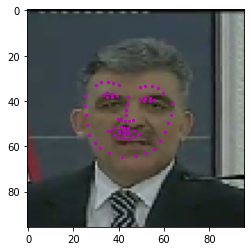

In [71]:
result = model.predict(test_image1)
result= result.astype('float').reshape(-1,2)
plt.imshow(test_image)
plt.scatter(result[:, 0], result[:, 1], s=20, marker='.', c='m')

print(result)
